In [1]:
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import reuters

import scipy.sparse as sparse

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer

from EM import ExpectationMaximation
from NB import NaiveBayes
from EM_extended import ExpectationMaximation_extended
from NB_extended import NaiveBayes_extended

In [2]:
#List of document ids
documents = reuters.fileids()
 
train_docs_id = list(filter(lambda doc: doc.startswith("train"),
documents))
test_docs_id = list(filter(lambda doc: doc.startswith("test"),
documents))

X_train_text = [reuters.raw(doc_id) for doc_id in train_docs_id]
X_test_text = [reuters.raw(doc_id) for doc_id in test_docs_id]

#create vector of word counts for the texts
vectorizer = TfidfVectorizer(stop_words=['english'], max_features=2000)
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

#create binary array with the class labels
mlb = MultiLabelBinarizer()
Y_train_complete = mlb.fit_transform([reuters.categories(doc_id)
for doc_id in train_docs_id])
Y_test_complete = mlb.transform([reuters.categories(doc_id)
for doc_id in test_docs_id])

categories_complete = reuters.categories()

In [3]:
#find the 10 classes with the most training examples and pick Y_train and Y_test for them
max_classes = list()
class_text_number = np.sum(Y_train_complete, axis=0)
for _ in range(10):
    argmax = np.argmax(class_text_number)
    max_classes.append(argmax)
    class_text_number[argmax]=0
Y_train = Y_train_complete[:,max_classes]
Y_test = Y_test_complete[:,max_classes]
categories = [categories_complete[i] for i in max_classes]

In [4]:
#create dictionary with accuracy scores and log model propability for every iteration of the em algorithm over 10 runs
em_scores = dict()
em_scores['log_model_prob'] = list()
em_scores['accuracy'] = list()
for i in range(10):
    y_train = Y_train[:,i]
    y_test = Y_test[:,i]
    X_rest, X_unlabeled, y_rest, y_unlabeled = train_test_split(X_train, y_train, test_size=7000, random_state=1, stratify=y_train)
    X_labeled, _, y_labeled, _ = train_test_split(X_rest, y_rest, train_size=50, random_state=3, stratify=y_rest)
    for n_iter in range(10):
            em = ExpectationMaximation(max_iter=n_iter, tol=0)
            em.fit(X_labeled, y_labeled, X_unlabeled)
            y_pred = em.predict(X_test)
            accuracy = accuracy_score(y_test,y_pred)
            em_scores['accuracy'].append(accuracy)
            em_scores['log_model_prob'].append(em.log_model_prob)

Text(0.5, 1.0, 'Test Accuracy vs Number of Labeled Documents in Training Set')

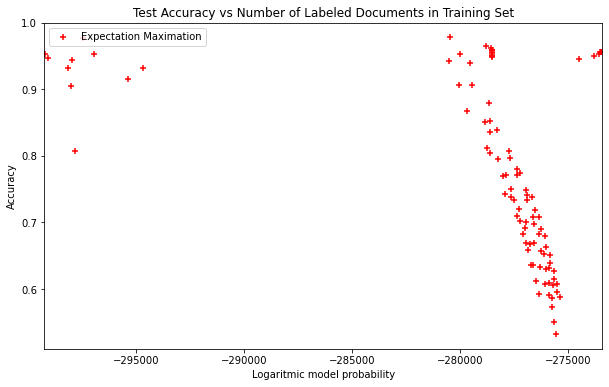

In [5]:
#create diagramm with log model probability vs accuracy for em algorithm
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.scatter(em_scores['log_model_prob'], em_scores['accuracy'], color='r', marker='+', label='Expectation Maximation')
ax.set_xlabel('Logaritmic model probability')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=np.min(em_scores['log_model_prob'])-50,
            right=np.max(em_scores['log_model_prob'])+50)
plt.legend(loc='upper left')
plt.title('Test Accuracy vs Number of Labeled Documents in Training Set')

In [6]:
#create dictionary with accuracy scores and log model propability for every iteration of the extended em algorithm over 10 runs
em_scores = dict()
em_scores['log_model_prob'] = list()
em_scores['accuracy'] = list()
for i in range(10):
    y_train = Y_train[:,i]
    y_test = Y_test[:,i]
    X_rest, X_unlabeled, y_rest, y_unlabeled = train_test_split(X_train, y_train, test_size=7000, random_state=3, stratify=y_train)
    X_labeled, _, y_labeled, _ = train_test_split(X_rest, y_rest, train_size=50, random_state=3, stratify=y_rest)
    for n_iter in range(10):
            em = ExpectationMaximation_extended(max_iter=n_iter, tol=0)
            em.fit(X_labeled, y_labeled, X_unlabeled, [15,1])
            y_pred = em.predict(X_test)
            accuracy = accuracy_score(y_test,y_pred)
            em_scores['accuracy'].append(accuracy)
            em_scores['log_model_prob'].append(em.log_model_prob)

Text(0.5, 1.0, 'Test Accuracy vs Number of Labeled Documents in Training Set')

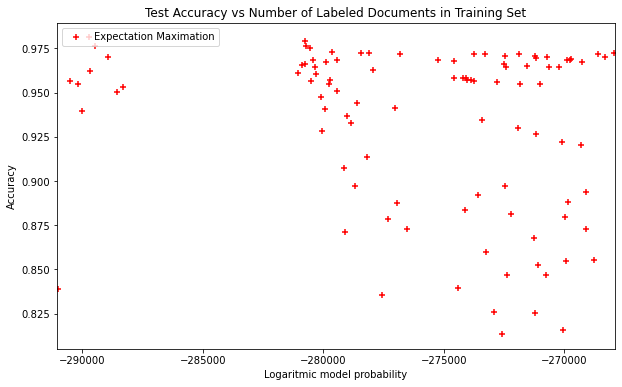

In [7]:
#create diagramm with log model probability vs accuracy for extended em algorithm
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.scatter(em_scores['log_model_prob'], em_scores['accuracy'], color='r', marker='+', label='Expectation Maximation')
ax.set_xlabel('Logaritmic model probability')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=np.min(em_scores['log_model_prob'])-50,
            right=np.max(em_scores['log_model_prob'])+50)
plt.legend(loc='upper left')
plt.title('Test Accuracy vs Number of Labeled Documents in Training Set')

In [8]:
#compute accuracy with NB,EM,NB_extended and EM_extended for the top 10 categories of reuters21578

#initialize dictionary with results for naive bayes
nb_test = dict()
nb_test['category'] = list()
nb_test['accuracy'] = list()
#initialize dictionary with results for expectation maximation
em_test = dict()
em_test['category'] = list()
em_test['accuracy'] = list()
#initialize dictionary with results for naive bayes
nb_extended_test = dict()
nb_extended_test['category'] = list()
nb_extended_test['accuracy'] = list()
#initialize dictionary with results for expectation maximation
em_extended_test = dict()
em_extended_test['category'] = list()
em_extended_test['accuracy'] = list()
for i in range(10):
    X_rest, X_unlabeled, Y_rest, Y_unlabeled = train_test_split(X_train, Y_train, test_size=7000, random_state=2, stratify=Y_train[:,i])
    y_test = Y_test[:,i]
    y_unlabeled = Y_unlabeled[:,i]
    y_rest = Y_rest[:,i]
    X_labeled, _, y_labeled, _ = train_test_split(X_rest, y_rest, train_size=50, random_state=2, stratify=y_rest)
    #NaiveBayes
    nb = NaiveBayes(alpha=1e-2)
    nb.fit(X_labeled,y_labeled)
    y_pred = nb.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    nb_test['category'].append(i)
    nb_test['accuracy'].append(accuracy)
    print("NB:", accuracy)
    #ExpectationMaximation
    em = ExpectationMaximation(max_iter=30, tol=10)
    em.fit(X_labeled, y_labeled, X_unlabeled)
    y_pred = em.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    em_test['category'].append(i)
    em_test['accuracy'].append(accuracy)
    print("EM:", accuracy)
    #extended NaiveBayes with best amount of subclasses
    n_negativ_best = 0
    n_positiv_best = 0
    best_accuracy = 0
    for n_negativ in range(5,50,5):
        for n_positiv in range(1,6):
            nb_extended = NaiveBayes_extended()
            nb_extended.fit(X_labeled, y_labeled, X_unlabeled, [n_negativ,n_positiv])
            y_pred = nb_extended.predict(X_test)
            accuracy = accuracy_score(y_test,y_pred)
            if (best_accuracy<accuracy):
                n_negativ_best = n_negativ
                n_positiv_best = n_positiv
                best_accuracy = accuracy
    nb_extended_test['category'].append(i)
    nb_extended_test['accuracy'].append(best_accuracy)
    print("NB_extended:", best_accuracy, " with [", n_negativ_best, ",", n_positiv_best, "]")
    #extended ExpectationMaximation with best amount of subclasses
    em_extended = ExpectationMaximation_extended(max_iter=10, tol=10)
    n_negativ_best = 0
    n_positiv_best = 0
    best_accuracy = 0
    for n_negativ in range(5,50,5):
        for n_positiv in range(1,6):
            em_extended = ExpectationMaximation_extended(max_iter=30, tol=10)
            em_extended.fit(X_labeled, y_labeled, X_unlabeled, [n_negativ,n_positiv])
            y_pred = em_extended.predict(X_test)
            accuracy = accuracy_score(y_test,y_pred)
            if (best_accuracy<accuracy):
                n_negativ_best = n_negativ
                n_positiv_best = n_positiv
                best_accuracy = accuracy
    em_extended_test['category'].append(i)
    em_extended_test['accuracy'].append(best_accuracy)
    print("EM_extended:", best_accuracy, " with [", n_negativ_best, ",", n_positiv_best, "]")

NB: 0.9562769128850612
EM: 0.9559456773766147
NB_extended: 0.9672076846637959  with [ 10 , 4 ]
EM_extended: 0.9764822789002982  with [ 45 , 5 ]
NB: 0.9354090758529314
EM: 0.5614441868168267
NB_extended: 0.941040079496522  with [ 5 , 3 ]
EM_extended: 0.9784696919509771  with [ 45 , 3 ]
NB: 0.8873799271281881
EM: 0.3829082477641603
NB_extended: 0.9519708512752567  with [ 5 , 1 ]
EM_extended: 0.9701888042398145  with [ 40 , 1 ]
NB: 0.9122225902616761
EM: 0.37197747598542563
NB_extended: 0.9605829744948658  with [ 5 , 1 ]
EM_extended: 0.9407088439880755  with [ 20 , 1 ]
NB: 0.9065915866180855
EM: 0.38588936734017887
NB_extended: 0.9476647896654521  with [ 5 , 1 ]
EM_extended: 0.8853925140775091  with [ 25 , 1 ]
NB: 0.8966545213646903
EM: 0.36303411725737
NB_extended: 0.9612454455117588  with [ 5 , 5 ]
EM_extended: 0.9211659489897317  with [ 45 , 1 ]
NB: 0.9115601192447831
EM: 0.3683338853925141
NB_extended: 0.9615766810202053  with [ 10 , 1 ]
EM_extended: 0.9662139781384564  with [ 10 , 1 

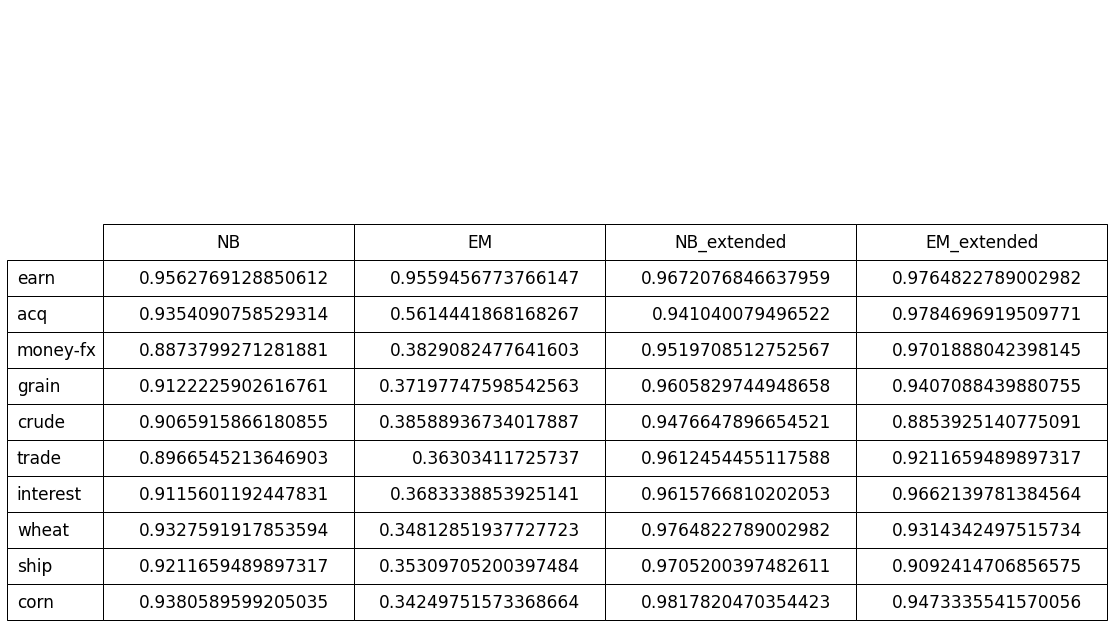

In [9]:
#create table with accuracies of NB, EM, NB_extended and EM_extended for the top 10 cattegories of reuters21578
accuracies = np.vstack([nb_test['accuracy'],em_test['accuracy'],nb_extended_test['accuracy'],em_extended_test['accuracy']]).T

columns = ('NB', 'EM', 'NB_extended', 'EM_extended')
rows = categories

#define figure and axes

fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table =  plt.table(cellText=accuracies, rowLabels=rows, colLabels=columns)
table.scale(3, 3)
table.set_fontsize(24)
plt.show()